In [208]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns

def base_data(entity, city_name):

    base_price = f"""

    WITH base AS (
        SELECT 
            ROUND(travel_time_distance_km, 0) AS delivery_distance,
            delivery_costs_eur,
            platform_order_code,
            delivery_fee_eur,
            dps_delivery_fee_eur,
            revenue_eur
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders`
        WHERE created_date >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)), INTERVAL 8 WEEK)
        AND created_date < DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY))
        AND is_own_delivery
        AND is_sent
        AND entity_id = '{entity}'
        AND city_name = '{city_name}'
        AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
        --AND zone_name IS NOT NULL
        --AND vendor_price_scheme_type = "Automatic scheme"
        --AND delivery_costs_local IS NOT NULL
        --AND delivery_fee_local IS NOT NULL
        --AND commission_local IS NOT NULL
        --AND travel_time_distance_km < 16
    ),
    distinct_distances AS (
        SELECT DISTINCT delivery_distance
        FROM base
    ),

    distance_buckets AS (
        SELECT 
            delivery_distance,
            NTILE(3) OVER (ORDER BY delivery_distance) AS dist_bucket
        FROM distinct_distances
    ),
    quantiles AS (
        SELECT 
            MAX(CASE WHEN dist_bucket = 1 THEN delivery_distance END) AS q1, -- upper bound of shortest third
            MAX(CASE WHEN dist_bucket = 2 THEN delivery_distance END) AS q2  -- upper bound of medium third
        FROM distance_buckets
    )

    SELECT
        CASE 
            WHEN b.delivery_distance <= q.q1 THEN 'short'
            WHEN b.delivery_distance <= q.q2 THEN 'medium'
            ELSE 'long'
        END AS distance_bucket,
        SUM(b.delivery_costs_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_cost_per_order,
        SUM(b.delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_fee_per_order,
        SUM(b.dps_delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS dps_delivery_fee_per_order,
        COUNT(DISTINCT b.platform_order_code) AS total_orders,
        SUM(b.revenue_eur) AS total_revenue,
        sum(b.delivery_costs_eur) AS total_costs,
    FROM base b
    CROSS JOIN quantiles q
    GROUP BY 1
    ORDER BY 1;

    """

    return base_price


def session_data(entity, city_name):

    session_metrics = f"""

    WITH session_data AS (
    SELECT 
        created_date,
        perseus_session_id, 
        perseus_client_id,
        (CASE WHEN transaction_no IS NOT NULL THEN 1 ELSE 0 END) AS session_converted,
    FROM `fulfillment-dwh-production.curated_data_shared.dps_cvr_events_perseus` as cvr
    where cvr.created_date >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)), INTERVAL 10 WEEK)
        AND cvr.created_date < DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)) 
        AND cvr.entity_id = '{entity}'
        AND cvr.dps_city_name = '{city_name}'
    ), tmp as (
    SELECT 
        created_date,
        COUNT(DISTINCT perseus_session_id) AS total_sessions,
        COUNT(DISTINCT perseus_client_id) AS total_users,
        SAFE_DIVIDE(COUNT(DISTINCT perseus_session_id), COUNT(DISTINCT perseus_client_id)) AS avg_sessions_per_user,
        SAFE_DIVIDE(COUNTIF(session_converted = 1), COUNT(DISTINCT perseus_session_id)) AS session_to_order_conversion_rate,
        STDDEV(SAFE_CAST(session_converted AS FLOAT64)) AS std_dev_session_to_order,
    FROM session_data
    group by 1
    )
    select round(avg(tmp.total_sessions),0) average_daily_sessions
        ,round(avg(session_to_order_conversion_rate),2) session_to_order_conversion_rate
        ,round(avg(std_dev_session_to_order),2) std_dev_session_to_order
        ,round(avg(avg_sessions_per_user),2) avg_sessions_per_user
    from tmp

    """

    return session_metrics

order_metrics = f"""

select avg(orders)
      ,stddev(orders)
from (
select date_trunc(created_date, week) week
      ,dsmto.perseus_client_id
      ,count(distinct platform_order_code) orders
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dsmto
WHERE created_date >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)), INTERVAL 10 WEEK)
  AND created_date < DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY))
  AND is_own_delivery
  AND entity_id = '{entity}'
group by 1,2
)

"""

def optimize_flat_fee(df, 
                      elasticity_short=-0.2, elasticity_medium=-0.25, elasticity_long=-0.28, 
                      weight_orders=1.0, weight_profit=1.0):

    # Ensure necessary columns are floats
    required_cols = ['delivery_cost_per_order', 'delivery_fee_per_order', 'dps_delivery_fee_per_order',
                     'total_orders', 'total_revenue', 'total_costs']
    df[required_cols] = df[required_cols].astype(float)

    # Extract values by distance bucket
    orders_short = df[df['distance_bucket'] == 'short']['total_orders'].iloc[0]
    orders_medium = df[df['distance_bucket'] == 'medium']['total_orders'].iloc[0]
    orders_long = df[df['distance_bucket'] == 'long']['total_orders'].iloc[0]

    fee_dps_short = df[df['distance_bucket'] == 'short']['dps_delivery_fee_per_order'].iloc[0]
    fee_dps_medium = df[df['distance_bucket'] == 'medium']['dps_delivery_fee_per_order'].iloc[0]
    fee_dps_long = df[df['distance_bucket'] == 'long']['dps_delivery_fee_per_order'].iloc[0]

    cost_delivery_short = df[df['distance_bucket'] == 'short']['delivery_cost_per_order'].iloc[0]
    cost_delivery_medium = df[df['distance_bucket'] == 'medium']['delivery_cost_per_order'].iloc[0]
    cost_delivery_long = df[df['distance_bucket'] == 'long']['delivery_cost_per_order'].iloc[0]

    # Baseline values for total orders and profit
    total_orders_original = orders_short + orders_medium + orders_long
    profit_original = (orders_short * (fee_dps_short - cost_delivery_short) +
                       orders_medium * (fee_dps_medium - cost_delivery_medium) +
                       orders_long * (fee_dps_long - cost_delivery_long))

    # Define the objective function for optimization
    def objective(flat_fee):
        # Calculate new orders for each bucket based on elasticity
        new_orders_short = orders_short * (flat_fee / fee_dps_short)**elasticity_short
        new_orders_medium = orders_medium * (flat_fee / fee_dps_medium)**elasticity_medium
        new_orders_long = orders_long * (flat_fee / fee_dps_long)**elasticity_long

        total_orders_new = new_orders_short + new_orders_medium + new_orders_long
        profit_new = (new_orders_short * (flat_fee - cost_delivery_short) +
                      new_orders_medium * (flat_fee - cost_delivery_medium) +
                      new_orders_long * (flat_fee - cost_delivery_long))
        
        orders_diff = (total_orders_new - total_orders_original)**2
        profit_diff = (profit_new - profit_original)**2
        
        return weight_orders * orders_diff + weight_profit * profit_diff

    # Initial guess for flat fee
    flat_fee_initial = (orders_short * fee_dps_short + orders_medium * fee_dps_medium + orders_long * fee_dps_long) / total_orders_original

    # Run optimization (flat fee must be > 0.01)
    result = minimize(objective, flat_fee_initial, bounds=[(0.01, None)])
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    optimal_flat_fee = result.x[0]

    # Calculate new total orders and profit using the optimal flat fee
    new_orders_short = orders_short * (optimal_flat_fee / fee_dps_short)**elasticity_short
    new_orders_medium = orders_medium * (optimal_flat_fee / fee_dps_medium)**elasticity_medium
    new_orders_long = orders_long * (optimal_flat_fee / fee_dps_long)**elasticity_long
    total_orders_new = new_orders_short + new_orders_medium + new_orders_long
    profit_new = (new_orders_short * (optimal_flat_fee - cost_delivery_short) +
                  new_orders_medium * (optimal_flat_fee - cost_delivery_medium) +
                  new_orders_long * (optimal_flat_fee - cost_delivery_long))

    # Return all necessary variables for further analysis, including profit_original
    return {
        'optimal_flat_fee': optimal_flat_fee,
        'orders_short': orders_short, 'orders_medium': orders_medium, 'orders_long': orders_long,
        'fee_dps_short': fee_dps_short, 'fee_dps_medium': fee_dps_medium, 'fee_dps_long': fee_dps_long,
        'cost_delivery_short': cost_delivery_short, 'cost_delivery_medium': cost_delivery_medium, 'cost_delivery_long': cost_delivery_long,
        'elasticity_short': elasticity_short, 'elasticity_medium': elasticity_medium, 'elasticity_long': elasticity_long,
        'new_orders_short': new_orders_short, 'new_orders_medium': new_orders_medium, 'new_orders_long': new_orders_long,
        'total_orders_original': total_orders_original,
        'total_orders_new': total_orders_new,
        'profit_original': profit_original,
        'profit_new': profit_new,
        'objective': objective
    }

def plot_objective_function(objective, optimal_flat_fee):

    fee_min = max(0.01, optimal_flat_fee * 0.5)
    fee_max = optimal_flat_fee * 1.5
    fee_values = np.linspace(fee_min, fee_max, 100)
    objective_values = [objective(fee) for fee in fee_values]

    plt.figure(figsize=(10, 6))
    plt.plot(fee_values, objective_values, label='Objective Function')
    plt.axvline(optimal_flat_fee, color='red', linestyle='--', label=f'Optimal Flat Fee = {optimal_flat_fee:.2f}')
    plt.title('Objective Function vs. Flat Fee')
    plt.xlabel('Flat Fee')
    plt.ylabel('Objective Function Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_comparison(buckets, original_values, new_values, metric='orders'):

    if metric.lower() == 'orders':
        y_label = 'Total Orders'
        title = 'Distribution of Orders by Distance Bucket'
        original_label = 'Original Orders'
        new_label = 'New Orders (Flat Fee)'
    elif metric.lower() == 'profit':
        y_label = 'Profit'
        title = 'Profit Comparison by Distance Bucket'
        original_label = 'Original Profit'
        new_label = 'New Profit (Flat Fee)'
    else:
        raise ValueError("Invalid metric. Please choose 'orders' or 'profit'.")
    
    x = np.arange(len(buckets))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, original_values, width, label=original_label)
    rects2 = ax.bar(x + width/2, new_values, width, label=new_label)

    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(buckets)
    ax.legend()

    # Function to add labels on top of each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.0f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    plt.show()


In [209]:
"""

PY_PE (entity)
Trujillo
Chiclayo
Piura
Huancayo

"""

entity = 'PY_PE'
city_name = 'Huancayo'

project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(base_data(entity, city_name)).to_dataframe()
session_data = client.query(session_data(entity, city_name)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Optimal flat fee: 0.896181268797712
Original total orders: 57163.0
New total orders: 57161.221730529105
Original profit: -14618.902351677749
New profit: -14619.281107427987


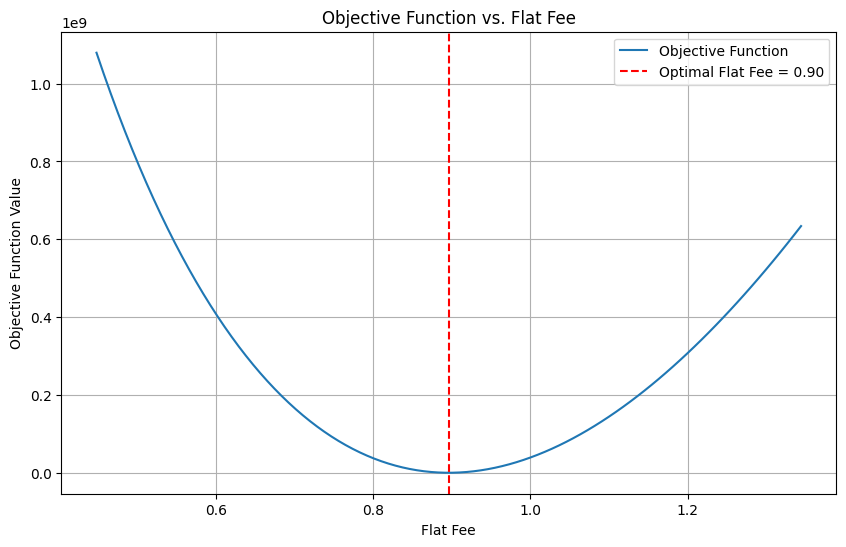

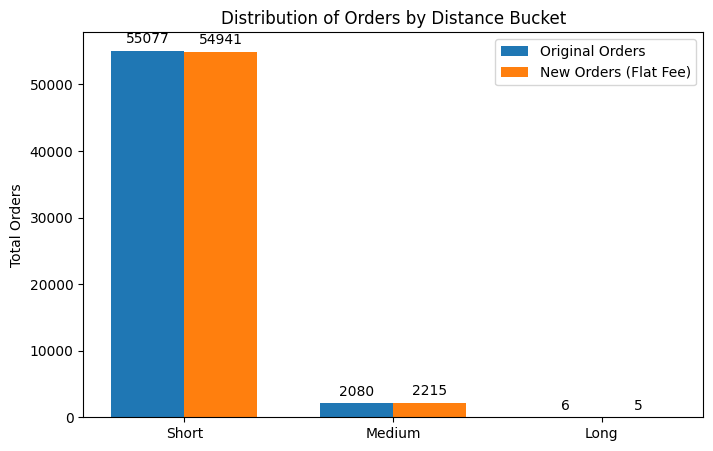

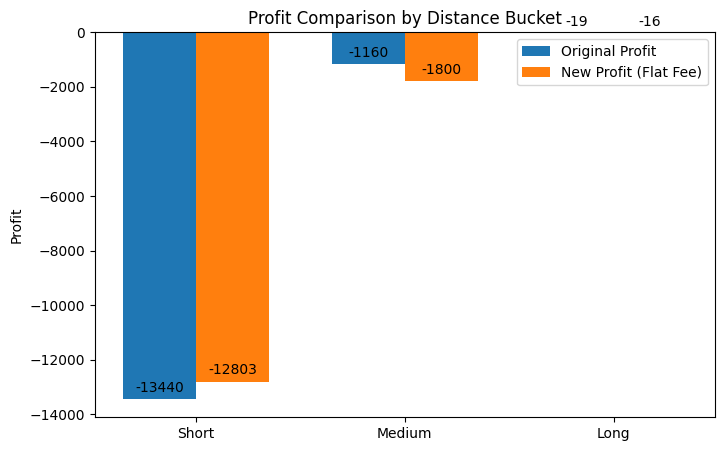

In [210]:
# Run optimization
results = optimize_flat_fee(test_df)

# Extract variables from the results dictionary
optimal_flat_fee = results['optimal_flat_fee']
orders_short = results['orders_short']
orders_medium = results['orders_medium']
orders_long = results['orders_long']
fee_dps_short = results['fee_dps_short']
fee_dps_medium = results['fee_dps_medium']
fee_dps_long = results['fee_dps_long']
elasticity_short = results['elasticity_short']
elasticity_medium = results['elasticity_medium']
elasticity_long = results['elasticity_long']
cost_delivery_short = results['cost_delivery_short']
cost_delivery_medium = results['cost_delivery_medium']
cost_delivery_long = results['cost_delivery_long']
new_orders_short = results['new_orders_short']
new_orders_medium = results['new_orders_medium']
new_orders_long = results['new_orders_long']
objective = results['objective']

print("Optimal flat fee:", optimal_flat_fee)
print("Original total orders:", results['total_orders_original'])
print("New total orders:", results['total_orders_new'])
print("Original profit:", results['profit_original'])
print("New profit:", results['profit_new'])


# Plot the objective function
plot_objective_function(objective, optimal_flat_fee)

# Plot comparison for orders by distance bucket
buckets = ['Short', 'Medium', 'Long']
orders_original = [orders_short, orders_medium, orders_long]
orders_new = [new_orders_short, new_orders_medium, new_orders_long]

plot_comparison(buckets, orders_original, orders_new, metric='orders')

# Calculate and plot profit per bucket
profit_short_original = orders_short * (fee_dps_short - cost_delivery_short)
profit_medium_original = orders_medium * (fee_dps_medium - cost_delivery_medium)
profit_long_original = orders_long * (fee_dps_long - cost_delivery_long)

profit_short_new = new_orders_short * (optimal_flat_fee - cost_delivery_short)
profit_medium_new = new_orders_medium * (optimal_flat_fee - cost_delivery_medium)
profit_long_new = new_orders_long * (optimal_flat_fee - cost_delivery_long)

profit_original = [profit_short_original, profit_medium_original, profit_long_original]
profit_new = [profit_short_new, profit_medium_new, profit_long_new]

plot_comparison(buckets, profit_original, profit_new, metric='profit')


In [205]:
from statsmodels.stats import power as smp
from statsmodels.stats.power import TTestIndPower


def power_analysis(
    metric_mean: float,
    metric_std: float,
    exp_perc_change: float,
    alpha: float = 0.05,
    power: float = 0.80,
    num_tests: int = 1,
    allocation_ratio: float = 1.0,  # treatment/control ratio
    segment_prop: float = 1.0      # % of users in the target segment (e.g., 0.3 for 30%)
) -> int:
    
    # if not isinstance(metric_mean, (np.ndarray, pd.Series)):
    #     raise ValueError("metric should be a NumPy array or pandas Series.")
    # if segment_prop <= 0 or segment_prop > 1:
    #     raise ValueError("segment_prop should be between 0 and 1.")
    
    corrected_alpha = alpha / num_tests
    
    control_mean = metric_mean
    control_std = metric_std
    test_mean = control_mean * (1 + exp_perc_change)
    test_std = control_std
    
    mean_diff = control_mean - test_mean
    pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
    effect_size = abs(mean_diff / pooled_std)
    
    analysis = smp.TTestIndPower()
    sample_size_per_group = analysis.solve_power(
        effect_size=effect_size,
        alpha=corrected_alpha,
        power=power,
        ratio=allocation_ratio
    )
    
    # Sample size only for the segment
    total_needed_in_segment = sample_size_per_group * (1 + allocation_ratio)
    total_needed_from_population = total_needed_in_segment / segment_prop

    print(f"Control mean: {round(control_mean, 3)}")
    print(f"Control std: {round(control_std, 3)}")
    print(f"Adjusted alpha: {round(corrected_alpha, 5)}")
    print(f"Min sample size (segment only): {int(round(total_needed_in_segment))}")
    print(f"Min sample size (total population to recruit enough segment): {int(round(total_needed_from_population))}")
    
    return int(round(total_needed_from_population))

In [218]:
exp_perc_change = 0.02 # Set the expected percentage change in the chosen metric caused by the treatment

min_sample_size = power_analysis(0.48, 0.25, exp_perc_change, num_tests = 4, segment_prop = 0.30)

duration_days = min_sample_size / 4009.0

print(duration_days)

Control mean: 0.48
Control std: 0.25
Adjusted alpha: 0.0125
Min sample size (segment only): 30252
Min sample size (total population to recruit enough segment): 100841
25.153654277874782


In [211]:
session_data

,average_daily_sessions,session_to_order_conversion_rate,std_dev_session_to_order,avg_sessions_per_user
0,3447.0,0.48,0.25,1.2


In [58]:
# np.random.seed(123)

# n = 10000 # Set number of observations
# p = 4 # Set number of pre-experiment covariates

# # Create pre-experiment covariates
# X = np.random.uniform(size=n * p).reshape((n, -1))

# # Nuisance parameters
# b = (
#     1.5 * X[:, 0] +
#     2.5 * X[:, 1] +
#     X[:, 2] ** 3 +     
#     X[:, 3] ** 2 +
#     X[:, 1] * X[:, 2]  
# )

# # Create some noise
# noise = np.random.normal(size=n)

# # Calculate outcome
# y = np.maximum(b + noise, 0)

# # Scale variables for interpretation
# df_pre = pd.DataFrame({"noise": noise * 1000,
#                    "u_income": X[:, 0] * 1000,                   
#                    "x_recency": X[:, 1] * 1000,
#                    "x_frequency": X[:, 2] * 1000,
#                    "x_value": X[:, 3] * 1000,
#                    "y_value": y * 1000     
# })

# # Visualise target metric
# sns.histplot(df_pre['y_value'], bins=30, kde=False)
# plt.xlabel('Sales Value')
# plt.ylabel('Frequency')
# plt.title('Sales Value')
# plt.show()


In [59]:
from typing import Union
import pandas as pd
import numpy as np
import statsmodels.stats.power as smp

def power_analysis(metric: Union[np.ndarray, pd.Series], exp_perc_change: float, alpha: float = 0.05, power: float = 0.80) -> int:
    
    # Validate input types
    if not isinstance(metric, (np.ndarray, pd.Series)):
        raise ValueError("metric should be a NumPy array or pandas Series.")
    
    # Calculate statistics
    control_mean = metric.mean()
    control_std = np.std(metric, ddof=1) # Use ddof=1 for sample standard deviation
    test_mean = control_mean * (1 + exp_perc_change)
    test_std = control_std # Assume the test group has the same standard deviation as the control group
    
    # Calculate (Cohen's D) effect size
    mean_diff = control_mean - test_mean
    pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
    effect_size = abs(mean_diff / pooled_std)  # Cohen's d should be positive
    
    # Run power analysis
    power_analysis = smp.TTestIndPower()
    sample_size = round(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power))
    total_sample_size = sample_size * 2  # assuming allocation ratio = 1.0
    
    print(f"Control mean: {round(control_mean, 3)}")
    print(f"Control std: {round(control_std, 3)}")
    print(f"Min sample size: {sample_size}")
    
    return sample_size

In [52]:
def power_analysis(
    metric: Union[np.ndarray, pd.Series],
    exp_perc_change: float,
    alpha: float = 0.05,
    power: float = 0.80
) -> int:
    
    # Validate input types
    if not isinstance(metric, (np.ndarray, pd.Series)):
        raise ValueError("metric should be a NumPy array or pandas Series.")
    
    # Stats
    control_mean = metric.mean()
    control_std = np.std(metric, ddof=1)
    test_mean = control_mean * (1 + exp_perc_change)
    test_std = control_std

    mean_diff = control_mean - test_mean
    pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
    effect_size = abs(mean_diff / pooled_std)

    # Solve power (explicit ratio to match advanced version)
    analysis = smp.TTestIndPower()
    sample_size_control = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1.0)
    total_sample_size = sample_size_control * (1 + 1.0)

    print(f"Control mean: {round(control_mean, 3)}")
    print(f"Control std: {round(control_std, 3)}")
    print(f"Min sample size per group: {int(round(sample_size_control))}")
    print(f"Total sample size: {int(round(total_sample_size))}")

    return int(round(total_sample_size))


In [63]:
session_data

,total_weekly_sessions,session_to_order_conversion_rate,std_dev_session_to_order,avg_sessions_per_user
0,180573.0,0.47,0.25,1.28


Control mean: 0.47
Control std: 0.25
Adjusted alpha: 0.0125
Min sample size (segment only): 31553
Min sample size (total population to recruit enough segment): 105178
0.582468032319339


In [39]:
session_data

,total_weekly_sessions,session_to_order_conversion_rate,std_dev_session_to_order,avg_sessions_per_user
0,9955.0,0.53,0.25,1.26


In [62]:
# def power_analysis(
#     metric: Union[np.ndarray, pd.Series],
#     exp_perc_change: float,
#     alpha: float = 0.05,
#     power: float = 0.80,
#     num_tests: int = 1,
#     allocation_ratio: float = 1.0,  # treatment/control ratio
#     segment_prop: float = 1.0      # % of users in the target segment (e.g., 0.3 for 30%)
# ) -> int:
    
#     if not isinstance(metric, (np.ndarray, pd.Series)):
#         raise ValueError("metric should be a NumPy array or pandas Series.")
#     if segment_prop <= 0 or segment_prop > 1:
#         raise ValueError("segment_prop should be between 0 and 1.")
    
#     corrected_alpha = alpha / num_tests
    
#     control_mean = metric.mean()
#     control_std = np.std(metric, ddof=1)
#     test_mean = control_mean * (1 + exp_perc_change)
#     test_std = control_std
    
#     mean_diff = control_mean - test_mean
#     pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
#     effect_size = abs(mean_diff / pooled_std)
    
#     analysis = smp.TTestIndPower()
#     sample_size_per_group = analysis.solve_power(
#         effect_size=effect_size,
#         alpha=corrected_alpha,
#         power=power,
#         ratio=allocation_ratio
#     )
    
#     # Sample size only for the segment
#     total_needed_in_segment = sample_size_per_group * (1 + allocation_ratio)
#     total_needed_from_population = total_needed_in_segment / segment_prop

#     print(f"Control mean: {round(control_mean, 3)}")
#     print(f"Control std: {round(control_std, 3)}")
#     print(f"Adjusted alpha: {round(corrected_alpha, 5)}")
#     print(f"Min sample size (segment only): {int(round(total_needed_in_segment))}")
#     print(f"Min sample size (total population to recruit enough segment): {int(round(total_needed_from_population))}")
    
#     return int(round(total_needed_from_population))

In [69]:
exp_perc_change = 0.02 # Set the expected percentage change in the chosen metric caused by the treatment

min_sample_size = power_analysis(df_pre["y_value"], exp_perc_change, num_tests = 4, segment_prop = 0.3)

duration_days = min_sample_size_total_population / total_dau

Control mean: 2856.419
Control std: 1461.528
Adjusted alpha: 0.0125
Min sample size (segment only): 29197
Min sample size (total population to recruit enough segment): 97323


In [21]:
# df_pre["y_value"].std()

np.float64(1461.5278814612054)

In [70]:
# min_sample_size

In [71]:
# import math
# from scipy.stats import norm

# def calculate_sample_size_continuous(baseline, mde, sigma, randomization_level='user', 
#                                      mde_is_percentage=True, r=1.0, alpha=0.05, power=0.8, 
#                                      design_effect=1.0):

#     z_alpha = norm.ppf(1 - alpha / 2)
#     z_beta = norm.ppf(power)
    
#     if sigma is None or mde is None:
#         raise ValueError("Please provide both sigma and mde.")
    
#     # Convert percentage-based MDE to absolute if needed.
#     if mde_is_percentage:
#         if baseline is None:
#             raise ValueError("For percentage-based MDE, please provide a baseline value.")
#         absolute_mde = baseline * mde
#     else:
#         absolute_mde = mde

#     n_control_raw = ((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2)
#     n_control = math.ceil(n_control_raw * design_effect)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_experiment_duration(n_control, n_treatment, total_weekly_users, f_control, f_treatment):

#     weekly_control = total_weekly_users * f_control
#     weekly_treatment = total_weekly_users * f_treatment
    
#     duration_control = n_control / weekly_control
#     duration_treatment = n_treatment / weekly_treatment
    
#     # Experiment duration is now measured in weeks
#     overall_duration_weeks = max(duration_control, duration_treatment)
#     return round(overall_duration_weeks)

# def calculate_metrics_sample_sizes_and_duration_multiple(metrics, total_weekly_users, f_control, f_treatment, num_treatment_groups, 
#                                                           randomization_level='user', mde_is_percentage=True, 
#                                                           alpha=0.05, power=0.8, design_effect=1.0):

#     results = {}
#     for metric_name, params in metrics.items():
#         baseline = params.get('baseline')
#         sigma = params.get('sigma')
#         mde = params.get('mde')
        
#         # For each treatment group, the allocation ratio is:
#         r = f_treatment / f_control
        
#         n_control, n_treatment = calculate_sample_size_continuous(
#             baseline=baseline,
#             mde=mde,
#             sigma=sigma,
#             randomization_level=randomization_level,
#             mde_is_percentage=mde_is_percentage,
#             r=r,
#             alpha=alpha,
#             power=power,
#             design_effect=design_effect
#         )
        
#         # Total sample size = control + (n_treatment for each treatment group)
#         total_sample_size = n_control + num_treatment_groups * n_treatment
        
#         # Calculate experiment duration in weeks (each treatment group gets f_treatment of traffic).
#         duration_weeks = calculate_experiment_duration(n_control, n_treatment, total_weekly_users, f_control, f_treatment)
        
#         results[metric_name] = {
#             'n_control': n_control,
#             'n_treatment_per_group': n_treatment,
#             'num_treatment_groups': num_treatment_groups,
#             'total_sample_size': total_sample_size,
#             'estimated_duration_weeks': duration_weeks
#         }
#     return results

# # ---------------------------
# # Weekly User-Level Sample Size Calculation
# # ---------------------------

# metrics = {
#     'orders_per_user': {
#         'baseline': 2856.4192237391917,   
#         'sigma': 1461.5278814612054,     
#         'mde': 0.02     
#     }
# }

# total_weekly_users = 284000

# f_control = 0.5         
# f_treatment = 0.5           
# num_treatment_groups = 1    

# results = calculate_metrics_sample_sizes_and_duration_multiple(
#     metrics, total_weekly_users, f_control, f_treatment, num_treatment_groups,
#     randomization_level='user', mde_is_percentage=True, alpha=0.05, power=0.8, design_effect=1.0
# )

# for metric, outcome in results.items():
#     print(f"Metric: {metric}")
#     print(f"  Control Sample Size: {outcome['n_control']}")
#     print(f"  Treatment Sample Size (per group): {outcome['n_treatment_per_group']}")
#     print(f"  Number of Treatment Groups: {outcome['num_treatment_groups']}")
#     print(f"  Total Sample Size: {outcome['total_sample_size']}")
#     print(f"  Estimated Experiment Duration (weeks): {outcome['estimated_duration_weeks']}\n")


In [79]:
import math
from scipy.stats import norm

def calculate_sample_size_continuous(baseline, mde, sigma, randomization_level='session',
                                     mde_is_percentage=True, r=1.0, alpha=0.05, power=0.8, 
                                     design_effect=1.0):

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    
    if sigma is None or mde is None:
        raise ValueError("Please provide both sigma and mde.")
    
    if mde_is_percentage:
        if baseline is None:
            raise ValueError("For percentage-based MDE, please provide a baseline value.")
        absolute_mde = baseline * mde
    else:
        absolute_mde = mde

    n_control_raw = ((z_alpha + z_beta) ** 2 * sigma ** 2 * (1 + 1 / r)) / (absolute_mde ** 2)

    n_control = math.ceil(n_control_raw * design_effect)
    n_treatment = math.ceil(n_control * r)
    
    return n_control, n_treatment

def calculate_experiment_duration(n_control, n_treatment, total_weekly_sessions, f_control, f_treatment):

    weekly_control = total_weekly_sessions * f_control
    weekly_treatment = total_weekly_sessions * f_treatment
    
    duration_control = n_control / weekly_control
    duration_treatment = n_treatment / weekly_treatment
    
    overall_duration_weeks = max(duration_control, duration_treatment)
    return round(overall_duration_weeks)

def calculate_metrics_sample_sizes_and_duration_multiple(metrics, total_weekly_sessions,
                                                         f_control, f_treatment, num_treatment_groups, 
                                                         intra_user_corr, randomization_level='session', 
                                                         mde_is_percentage=True, alpha=0.05, power=0.8):

    design_effect = 1 + intra_user_corr

    results = {}
    for metric_name, params in metrics.items():
        baseline = params.get('baseline')
        sigma = params.get('sigma')
        mde = params.get('mde')
        
        r = f_treatment / f_control
        
        n_control, n_treatment = calculate_sample_size_continuous(
            baseline=baseline,
            mde=mde,
            sigma=sigma,
            randomization_level=randomization_level,
            mde_is_percentage=mde_is_percentage,
            r=r,
            alpha=alpha,
            power=power,
            design_effect=design_effect
        )
        
        total_sample_size = n_control + num_treatment_groups * n_treatment
        
        duration_weeks = calculate_experiment_duration(n_control, n_treatment, total_weekly_sessions, f_control, f_treatment)
        
        results[metric_name] = {
            'n_control_sessions': n_control,
            'n_treatment_sessions_per_group': n_treatment,
            'num_treatment_groups': num_treatment_groups,
            'total_sample_size_sessions': total_sample_size,
            'estimated_duration_weeks': duration_weeks 
        }
    
    return results

# ---------------------------
# Weekly Session-Level Sample Size Calculation
# ---------------------------

intra_user_corr = 0.1

metrics = {
    'session_to_order_conversion': {
        'baseline': 0.47, 
        'sigma': 0.25,
        'mde': 0.02
    }
}

total_weekly_sessions = 180573.0  

f_control = 0.05         
f_treatment = 0.05           
num_treatment_groups = 5     

session_results = calculate_metrics_sample_sizes_and_duration_multiple(
    metrics, total_weekly_sessions, f_control, f_treatment, 
    num_treatment_groups, intra_user_corr, randomization_level='session', 
    mde_is_percentage=True, alpha=0.05, power=0.8
)

for metric, outcome in session_results.items():
    print(f"Metric: {metric}")
    print(f"  Control Sample Size (Sessions): {outcome['n_control_sessions']}")
    print(f"  Treatment Sample Size (Sessions per group): {outcome['n_treatment_sessions_per_group']}")
    print(f"  Number of Treatment Groups: {outcome['num_treatment_groups']}")
    print(f"  Total Sample Size (Sessions): {outcome['total_sample_size_sessions']}")
    print(f"  Estimated Experiment Duration (weeks): {outcome['estimated_duration_weeks']}\n")


Metric: session_to_order_conversion
  Control Sample Size (Sessions): 12214
  Treatment Sample Size (Sessions per group): 12214
  Number of Treatment Groups: 5
  Total Sample Size (Sessions): 73284
  Estimated Experiment Duration (weeks): 1



In [77]:
session_data

,total_weekly_sessions,session_to_order_conversion_rate,std_dev_session_to_order,avg_sessions_per_user
0,180573.0,0.47,0.25,1.28


In [75]:
import math
from scipy.stats import norm

def calculate_sample_size_continuous(baseline, mde, sigma, randomization_level='session',
                                     mde_is_percentage=True, r=1.0, alpha=0.05, power=0.8, 
                                     design_effect=1.0):

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    
    if sigma is None or mde is None:
        raise ValueError("Please provide both sigma and mde.")
    
    # Convert percentage-based MDE to absolute if needed.
    if mde_is_percentage:
        if baseline is None:
            raise ValueError("For percentage-based MDE, please provide a baseline value.")
        absolute_mde = baseline * mde
    else:
        absolute_mde = mde

    # Compute raw sample size (before adjustment)
    n_control_raw = ((z_alpha + z_beta) ** 2 * sigma ** 2 * (1 + 1 / r)) / (absolute_mde ** 2)

    # Apply design effect to adjust for session-level clustering
    n_control = math.ceil(n_control_raw * design_effect)
    n_treatment = math.ceil(n_control * r)
    
    return n_control, n_treatment

def calculate_experiment_duration(n_control, n_treatment, total_daily_sessions, f_control, f_treatment):

    daily_control = total_daily_sessions * f_control
    daily_treatment = total_daily_sessions * f_treatment
    
    duration_control = n_control / daily_control
    duration_treatment = n_treatment / daily_treatment
    
    # Experiment duration is determined by the slowest accumulating group.
    overall_duration = max(duration_control, duration_treatment)
    return overall_duration

def calculate_metrics_sample_sizes_and_duration_multiple(metrics, total_daily_users, avg_sessions_per_user,
                                                         f_control, f_treatment, num_treatment_groups, 
                                                         intra_user_corr, randomization_level='session', 
                                                         mde_is_percentage=True, alpha=0.05, power=0.8):

    # Compute session-level design effect
    design_effect = 1 + (avg_sessions_per_user - 1) * intra_user_corr

    # Convert user-level daily volume to session-level daily volume
    total_daily_sessions = total_daily_users * avg_sessions_per_user

    results = {}
    for metric_name, params in metrics.items():
        baseline = params.get('baseline')
        sigma = params.get('sigma')
        mde = params.get('mde')
        
        # Allocation ratio between treatment and control
        r = f_treatment / f_control
        
        # Compute sample sizes with session-level adjustments
        n_control, n_treatment = calculate_sample_size_continuous(
            baseline=baseline,
            mde=mde,
            sigma=sigma,
            randomization_level=randomization_level,
            mde_is_percentage=mde_is_percentage,
            r=r,
            alpha=alpha,
            power=power,
            design_effect=design_effect
        )
        
        # Total sample size across all treatment groups
        total_sample_size = n_control + num_treatment_groups * n_treatment
        
        # Calculate experiment duration based on session-level traffic
        duration = calculate_experiment_duration(n_control, n_treatment, total_daily_sessions, f_control, f_treatment)
        
        results[metric_name] = {
            'n_control_sessions': n_control,
            'n_treatment_sessions_per_group': n_treatment,
            'num_treatment_groups': num_treatment_groups,
            'total_sample_size_sessions': total_sample_size,
            'estimated_duration_days': duration
        }
    
    return results

# ---------------------------
# Session-Level Sample Size Calculation
# ---------------------------

# Assume 3 sessions per user on average
avg_sessions_per_user = 2.23  

# Assume intra-user correlation (ρ) from previous analysis
intra_user_corr = 0.5  # Example value

# Conversion rate metric at the session level
metrics = {
    'session_to_order_conversion': {
        'baseline': 0.47, 
        'sigma': 0.25,
        'mde': 0.02
    }
}

# Corrected total daily users
total_daily_users = 180573.0  # No unnecessary multiplication

f_control = 0.06         
f_treatment = 0.06           
num_treatment_groups = 4     

# Run session-level sample size calculation
session_results = calculate_metrics_sample_sizes_and_duration_multiple(
    metrics, total_daily_users, avg_sessions_per_user, f_control, f_treatment, 
    num_treatment_groups, intra_user_corr, randomization_level='session', 
    mde_is_percentage=True, alpha=0.05, power=0.8
)

# Display results
for metric, outcome in session_results.items():
    print(f"Metric: {metric}")
    print(f"  Control Sample Size (Sessions): {outcome['n_control_sessions']}")
    print(f"  Treatment Sample Size (Sessions per group): {outcome['n_treatment_sessions_per_group']}")
    print(f"  Number of Treatment Groups: {outcome['num_treatment_groups']}")
    print(f"  Total Sample Size (Sessions): {outcome['total_sample_size_sessions']}")
    print(f"  Estimated Experiment Duration (days): {outcome['estimated_duration_days']}\n")


Metric: session_to_order_conversion
  Control Sample Size (Sessions): 17933
  Treatment Sample Size (Sessions per group): 17933
  Number of Treatment Groups: 4
  Total Sample Size (Sessions): 89665
  Estimated Experiment Duration (days): 0.7422394300250167



In [73]:
session_data

,total_weekly_sessions,session_to_order_conversion_rate,std_dev_session_to_order,avg_sessions_per_user
0,180573.0,0.47,0.25,1.28


In [82]:
# def calculate_sample_size_continuous(baseline, mde, sigma, mde_is_percentage=False, r=1.0, alpha=0.05, power=0.8, design_effect=1.0):

#     z_alpha = norm.ppf(1 - alpha / 2)
#     z_beta = norm.ppf(power)
    
#     if sigma is None or mde is None:
#         raise ValueError("Please provide both sigma and mde.")
    
#     # Convert percentage MDE to an absolute difference if needed.
#     if mde_is_percentage:
#         if baseline is None:
#             raise ValueError("For percentage-based MDE, please provide a baseline value.")
#         absolute_mde = baseline * mde
#     else:
#         absolute_mde = mde

#     # Calculate the raw sample size for the control group.
#     n_control_raw = ((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2)
#     n_control = math.ceil(n_control_raw * design_effect)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_duration(n_control, n_treatment, total_daily_sessions, f_control, f_treatment):
#     """
#     Calculates the overall experiment duration (in days) based on sample size requirements 
#     for control and treatment groups, assuming the total_daily_sessions is the raw count of sessions.
#     """
#     daily_control = total_daily_sessions * f_control
#     daily_treatment = total_daily_sessions * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
    
#     overall_duration = max(duration_control, duration_treatment)
#     return overall_duration

# # ---------------------------
# # Example Usage for Continuous Outcomes (Sessions)
# # ---------------------------
# baseline_revenue = 1.14       # Baseline revenue per session
# sigma_cont = 0.018             # Standard deviation per session
# mde_revenue_pct = 1        # MDE as a fraction (1% change)
# f_control = 0.80              # 80% of sessions to control
# f_treatment = 0.05            # 5% of sessions to each treatment
# r = f_treatment / f_control   # Allocation ratio

# # Suppose from previous data you estimate an average of 2 sessions per user and an ICC of 0.1.
# # Then design_effect = 1 + (2 - 1) * 0.1 = 1.1.
# design_effect = 1

# # Calculate sample sizes with the design effect adjustment.
# n_control_cont, n_treatment_cont = calculate_sample_size_continuous(
#     baseline=baseline_revenue,
#     mde=mde_revenue_pct,
#     sigma=sigma_cont,
#     mde_is_percentage=False,
#     r=r,
#     alpha=0.05,
#     power=0.8,
#     design_effect=design_effect
# )

# num_treatments = 4  # For example, 4 treatment groups.
# total_sample_size = n_control_cont + num_treatments * n_treatment_cont

# # If total_daily_sessions is the number of sessions per day:
# total_daily_sessions = 54000

# overall_duration = calculate_duration(
#     n_control_cont,
#     n_treatment_cont,
#     total_daily_sessions,
#     f_control,
#     f_treatment
# )

# print("Adjusted Continuous Outcome Sample Sizes (with design effect):")
# print("Control:", n_control_cont, "Treatment (each):", n_treatment_cont)
# print("Total sample size (80% control, 4 x 5% treatments):", total_sample_size)
# print("Overall experiment duration (days):", overall_duration)


In [73]:
# import math
# from scipy.stats import norm

# def calculate_sample_size_continuous_user(baseline, mde, sigma, mde_is_percentage=True, r=1.0, alpha=0.05, power=0.8):
#     """
#     Calculate required sample sizes for a continuous outcome measured at the user level.
    
#     Parameters:
#         baseline (float): baseline user-level metric (e.g., revenue per user).
#         mde (float): minimum detectable effect. If mde_is_percentage is True,
#                      mde should be provided as a fraction (e.g., 0.01 for 1% change).
#                      Otherwise, mde is treated as an absolute difference.
#         sigma (float): standard deviation of the user-level metric.
#         mde_is_percentage (bool): whether mde is provided as a percentage (default: True).
#         r (float): allocation ratio (treatment/control).
#         alpha (float): significance level (default: 0.05).
#         power (float): desired statistical power (default: 0.8).
    
#     Returns:
#         tuple: (n_control, n_treatment) where each is the required number of users.
#     """
#     z_alpha = norm.ppf(1 - alpha / 2)
#     z_beta = norm.ppf(power)
    
#     if sigma is None or mde is None:
#         raise ValueError("Please provide both sigma and mde.")
    
#     # Convert percentage MDE to an absolute difference if needed.
#     if mde_is_percentage:
#         if baseline is None:
#             raise ValueError("For percentage-based MDE, please provide a baseline value.")
#         absolute_mde = baseline * mde
#     else:
#         absolute_mde = mde

#     # Calculate the raw sample size for the control group.
#     n_control_raw = ((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2)
#     n_control = math.ceil(n_control_raw)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_experiment_duration(n_control, n_treatment, total_daily_users, f_control, f_treatment):
#     """
#     Calculates the overall experiment duration (in days) based on the required sample sizes 
#     for the control and treatment groups, given a daily user traffic allocation.
    
#     Parameters:
#         n_control (int): required sample size for the control group.
#         n_treatment (int): required sample size for each treatment group.
#         total_daily_users (int): total number of users available per day.
#         f_control (float): fraction of users allocated to the control group.
#         f_treatment (float): fraction of users allocated to each treatment group.
        
#     Returns:
#         float: estimated number of days required to reach the necessary sample size.
#     """
#     daily_control = total_daily_users * f_control
#     daily_treatment = total_daily_users * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
    
#     # The experiment must run until both groups have reached the required sample size.
#     overall_duration = max(duration_control, duration_treatment)
#     return overall_duration

# # ---------------------------
# # Example Usage for User-Level Continuous Outcomes
# # ---------------------------
# # Suppose the baseline revenue per user is $50 with a standard deviation of $20.
# baseline_revenue_user = 5.10      # Baseline revenue per user (dollars)
# sigma_user = 41.08                 # Standard deviation of revenue per user
# mde_revenue_pct = 0.02          # MDE as 1% change (expressed as a fraction)
# f_control = 0.5                # 80% of users to control
# f_treatment = 0.5              # 5% of users to each treatment group
# r = f_treatment / f_control    # Allocation ratio: treatment/control

# # Calculate sample sizes for user-level data.
# n_control_user, n_treatment_user = calculate_sample_size_continuous_user(
#     baseline=baseline_revenue_user,
#     mde=mde_revenue_pct,
#     sigma=sigma_user,
#     mde_is_percentage=True,  # Now using percentage mode for user-level metrics
#     r=r,
#     alpha=0.05,
#     power=0.8
# )

# num_treatments = 4  # Example: 4 treatment groups.
# total_sample_size = n_control_user + num_treatments * n_treatment_user

# # Suppose you have a daily traffic of 5000 users.
# total_daily_users = 54000

# experiment_duration = calculate_experiment_duration(
#     n_control_user,
#     n_treatment_user,
#     total_daily_users,
#     f_control,
#     f_treatment
# )

# print("User-level Sample Sizes:")
# print("Control:", n_control_user, "Treatment (each):", n_treatment_user)
# print("Total sample size (80% control, 4 x 5% treatments):", total_sample_size)
# print("Estimated experiment duration (days):", experiment_duration)


In [81]:
# import math
# from scipy.stats import norm

# def calculate_sample_size_continuous(baseline, mde, sigma, randomization_level='user', 
#                                      mde_is_percentage=True, r=1.0, alpha=0.05, power=0.8, 
#                                      design_effect=1.0):

#     z_alpha = norm.ppf(1 - alpha / 2)
#     z_beta = norm.ppf(power)
    
#     if sigma is None or mde is None:
#         raise ValueError("Please provide both sigma and mde.")
    
#     # Convert percentage MDE to an absolute difference if needed.
#     if mde_is_percentage:
#         if baseline is None:
#             raise ValueError("For percentage-based MDE, please provide a baseline value.")
#         absolute_mde = baseline * mde
#     else:
#         absolute_mde = mde

#     # The core calculation is the same for either level, but ensure your inputs are appropriate.
#     n_control_raw = ((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2)
#     n_control = math.ceil(n_control_raw * design_effect)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_experiment_duration(n_control, n_treatment, total_daily_units, f_control, f_treatment):
    
#     daily_control = total_daily_units * f_control
#     daily_treatment = total_daily_units * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
    
#     # The experiment must run until both groups have reached the required sample size.
#     overall_duration = max(duration_control, duration_treatment)
#     return overall_duration

# # ---------------------------
# # Example Usage
# # ---------------------------

# # User-Level Randomization Example:
# # Suppose historical data gives a user-level baseline of $50 revenue per user with a standard deviation of $20.
# baseline_user = 50          # User-level metric (e.g., revenue per user)
# sigma_user = 20             # Standard deviation at the user level
# mde_user_pct = 0.01         # 1% change (as a fraction)
# # For a balanced design, let half the users be in control and half in treatment.
# f_control_user = 0.5
# f_treatment_user = 0.5
# r_user = f_treatment_user / f_control_user  # For balanced randomization, r = 1
# n_control_user, n_treatment_user = calculate_sample_size_continuous(
#     baseline=baseline_user,
#     mde=mde_user_pct,
#     sigma=sigma_user,
#     randomization_level='user',
#     mde_is_percentage=True,
#     r=r_user,
#     design_effect=1.0
# )
# total_daily_users = 5000  # Daily user traffic
# duration_user = calculate_experiment_duration(n_control_user, n_treatment_user,
#                                               total_daily_users, f_control_user, f_treatment_user)

# # Session-Level Randomization Example:
# # Suppose the baseline per session is $1.14 revenue with a standard deviation of $0.018.
# baseline_session = 1.14     # Session-level metric (e.g., revenue per session)
# sigma_session = 0.018       # Standard deviation at the session level
# mde_session_pct = 0.01      # 1% change (as a fraction)
# # For session-level, assume 80% of sessions go to control and 5% to each treatment group.
# f_control_session = 0.80
# f_treatment_session = 0.05
# r_session = f_treatment_session / f_control_session
# n_control_session, n_treatment_session = calculate_sample_size_continuous(
#     baseline=baseline_session,
#     mde=mde_session_pct,
#     sigma=sigma_session,
#     randomization_level='session',
#     mde_is_percentage=True,
#     r=r_session,
#     design_effect=1.0  # You might increase this if sessions are heavily clustered by user.
# )
# total_daily_sessions = 54000  # Daily session count
# duration_session = calculate_experiment_duration(n_control_session, n_treatment_session,
#                                                  total_daily_sessions, f_control_session, f_treatment_session)

# # Print Results:
# print("User-Level Randomization:")
# print("Control Sample Size:", n_control_user, "Treatment Sample Size:", n_treatment_user)
# print("Estimated Experiment Duration (days):", duration_user)
# print("\nSession-Level Randomization:")
# print("Control Sample Size:", n_control_session, "Treatment Sample Size:", n_treatment_session)
# print("Estimated Experiment Duration (days):", duration_session)


In [65]:
# import math
# from scipy.stats import norm

# def calculate_sample_size(metric_type, 
#                           baseline=None, mde=None, mde_is_percentage=False, sigma=None, 
#                           r=1.0, alpha=0.05, power=0.8, m_comparisons=1):

#     # Adjust alpha for multiple comparisons using Bonferroni correction.
#     alpha_adjusted = alpha / m_comparisons
    
#     # Calculate the z-values for the significance level and power.
#     z_alpha = norm.ppf(1 - alpha_adjusted/2)
#     z_beta = norm.ppf(power)
    
#     if metric_type == 'proportion':
#         if baseline is None or mde is None:
#             raise ValueError("For binary outcomes, please provide both baseline and mde.")
#         p0 = baseline
#         p1 = baseline + mde  # mde is an absolute change (or computed externally as p0 * some percentage)
#         p_avg = (p0 + p1) / 2.0
        
#         numerator = (z_alpha * math.sqrt(p_avg * (1 - p_avg) * (1 + 1/r)) +
#                      z_beta * math.sqrt(p0 * (1 - p0) + (p1 * (1 - p1)) / r)) ** 2
#         denominator = (p1 - p0) ** 2
        
#         n_control = math.ceil(numerator / denominator)
#         n_treatment = math.ceil(n_control * r)
    
#     elif metric_type == 'continuous':
#         if sigma is None or mde is None:
#             raise ValueError("For continuous outcomes, please provide both sigma and mde.")
#         # If mde is a percentage, convert it to an absolute effect using the baseline.
#         if mde_is_percentage:
#             if baseline is None:
#                 raise ValueError("For percentage-based MDE, please provide a baseline value.")
#             absolute_mde = baseline * mde  # For example, baseline=20, mde=0.05 => absolute_mde=1
#         else:
#             absolute_mde = mde
        
#         n_control = math.ceil(((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2))
#         n_treatment = math.ceil(n_control * r)
    
#     else:
#         raise ValueError("metric_type must be either 'proportion' or 'continuous'.")
    
#     return n_control, n_treatment

# def calculate_duration(n_control, n_treatment, total_daily_visitors, f_control, f_treatment, num_treatments):

#     daily_control = total_daily_visitors * f_control
#     daily_treatment = total_daily_visitors * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
    
#     # The overall experiment must run until the slowest arm (usually treatment) meets its sample size.
#     overall_duration = max(duration_control, duration_treatment)
#     return overall_duration

# # ---------------------------
# # Example Usage for Proportions
# # ---------------------------
# p0 = 0.20                        # Baseline conversion rate (20%)
# mde_prop = p0 * 0.01             # MDE as 5% of baseline (absolute change = 0.20 * 0.05 = 0.01)
# # For a simple two-group test, allocation fractions are:
# f_control_prop = 0.80           # 80% of visitors to control
# f_treatment_prop = 0.05         # 5% of visitors to each treatment
# num_treatments = 4              # Number of treatment groups
# # Allocation ratio for one treatment vs. control:
# r_prop = f_treatment_prop / f_control_prop  # 0.05 / 0.80 = 0.0625
# m_comparisons = num_treatments  # Use Bonferroni correction for multiple comparisons

# n_control_prop, n_treatment_prop = calculate_sample_size(
#     'proportion', 
#     baseline=p0, 
#     mde=mde_prop, 
#     r=r_prop, 
#     alpha=0.05, 
#     power=0.8, 
#     m_comparisons=m_comparisons
# )
# total_sample_size_prop = n_control_prop + num_treatments * n_treatment_prop
# overall_duration_prop = calculate_duration(
#     n_control_prop, 
#     n_treatment_prop, 
#     total_daily_visitors=100000, 
#     f_control=f_control_prop, 
#     f_treatment=f_treatment_prop, 
#     num_treatments=num_treatments
# )

# print("Binary outcome sample sizes:")
# print("Control:", n_control_prop, "Treatment (each):", n_treatment_prop)
# print("Total sample size (80% control, 4 x 5% treatments):", total_sample_size_prop)
# print("Overall experiment duration (days):", overall_duration_prop)

# # ---------------------------
# # Example Usage for Continuous Outcomes
# # ---------------------------
# baseline_revenue = 2.62            # Baseline revenue per user
# sigma_cont = 0.68                 # Estimated standard deviation of revenue per user
# mde_revenue_pct = 0.01           # MDE as a decimal percentage change (0.05 means 5% of baseline; i.e., 20 * 0.05 = 1)
# f_control_cont = 0.80            # 80% of visitors to control
# f_treatment_cont = 0.05          # 5% of visitors to each treatment
# r_cont = f_treatment_cont / f_control_cont  # 0.05 / 0.80 = 0.0625

# n_control_cont, n_treatment_cont = calculate_sample_size(
#     'continuous', 
#     baseline=baseline_revenue, 
#     sigma=sigma_cont, 
#     mde=mde_revenue_pct, 
#     mde_is_percentage=True, 
#     r=r_cont
# )
# total_sample_size_cont = n_control_cont + num_treatments * n_treatment_cont
# overall_duration_cont = calculate_duration(
#     n_control_cont, 
#     n_treatment_cont, 
#     total_daily_visitors=201926, 
#     f_control=f_control_cont, 
#     f_treatment=f_treatment_cont, 
#     num_treatments=num_treatments
# )

# print("\nContinuous outcome sample sizes (using percentage MDE):")
# print("Control:", n_control_cont, "Treatment (each):", n_treatment_cont)
# print("Total sample size (80% control, 4 x 5% treatments):", total_sample_size_cont)
# print("Overall experiment duration (days):", overall_duration_cont)


In [28]:
# import numpy as np
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt

# def optimize_flat_fee(df, 
#                       E_S=-0.2, E_M=-0.25, E_L=-0.28, 
#                       w_Q=1.0, w_pi=1.0):
    
#     # Ensure necessary columns are floats
#     cols = ['delivery_cost_per_order', 'delivery_fee_per_order', 'dps_delivery_fee_per_order',
#             'total_orders', 'total_revenue', 'total_costs']
#     df[cols] = df[cols].astype(float)
    
#     # Extract values by distance bucket
#     Q_S = df[df['distance_bucket'] == 'short']['total_orders'].iloc[0]
#     Q_M = df[df['distance_bucket'] == 'medium']['total_orders'].iloc[0]
#     Q_L = df[df['distance_bucket'] == 'long']['total_orders'].iloc[0]

#     P_S = df[df['distance_bucket'] == 'short']['dps_delivery_fee_per_order'].iloc[0]
#     P_M = df[df['distance_bucket'] == 'medium']['dps_delivery_fee_per_order'].iloc[0]
#     P_L = df[df['distance_bucket'] == 'long']['dps_delivery_fee_per_order'].iloc[0]

#     C_S = df[df['distance_bucket'] == 'short']['delivery_cost_per_order'].iloc[0]
#     C_M = df[df['distance_bucket'] == 'medium']['delivery_cost_per_order'].iloc[0]
#     C_L = df[df['distance_bucket'] == 'long']['delivery_cost_per_order'].iloc[0]

#     # Baseline values for orders and profit
#     Q_orig = Q_S + Q_M + Q_L
#     profit_orig = (Q_S * (P_S - C_S) +
#                    Q_M * (P_M - C_M) +
#                    Q_L * (P_L - C_L))

#     # Define the objective function for optimization
#     def objective(F):
#         Q_S_new = Q_S * (F / P_S)**E_S
#         Q_M_new = Q_M * (F / P_M)**E_M
#         Q_L_new = Q_L * (F / P_L)**E_L

#         Q_new = Q_S_new + Q_M_new + Q_L_new
#         profit_new = (Q_S_new * (F - C_S) +
#                       Q_M_new * (F - C_M) +
#                       Q_L_new * (F - C_L))
        
#         orders_diff = (Q_new - Q_orig)**2
#         profit_diff = (profit_new - profit_orig)**2
        
#         return w_Q * orders_diff + w_pi * profit_diff

#     # Initial Guess
#     F_init = (Q_S * P_S + Q_M * P_M + Q_L * P_L) / Q_orig

#     # Run optimization (F must be > 0.01)
#     result = minimize(objective, F_init, bounds=[(0.01, None)])
    
#     if not result.success:
#         raise ValueError("Optimization failed: " + result.message)

#     F_opt = result.x[0]

#     # Calculate new total orders and profit using the optimal fee
#     Q_S_new = Q_S * (F_opt / P_S)**E_S
#     Q_M_new = Q_M * (F_opt / P_M)**E_M
#     Q_L_new = Q_L * (F_opt / P_L)**E_L
#     Q_new = Q_S_new + Q_M_new + Q_L_new
#     profit_new = (Q_S_new * (F_opt - C_S) +
#                   Q_M_new * (F_opt - C_M) +
#                   Q_L_new * (F_opt - C_L))

#     return F_opt, Q_new, profit_new, objective


# def plot_objective_function(objective, F_opt):
   
#     F_min = max(0.01, F_opt * 0.5)
#     F_max = F_opt * 1.5
#     F_values = np.linspace(F_min, F_max, 100)
#     objective_values = [objective(f) for f in F_values]

#     plt.figure(figsize=(10, 6))
#     plt.plot(F_values, objective_values, label='Objective Function')
#     plt.axvline(F_opt, color='red', linestyle='--', label=f'Optimal Fee = {F_opt:.2f}')
#     plt.title('Objective Function vs. Flat Fee')
#     plt.xlabel('Flat Fee (F)')
#     plt.ylabel('Objective Function Value')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# #Example usage:
# F_opt, Q_new, profit_new, objective = optimize_flat_fee(test_df)
# plot_objective_function(objective, F_opt)
# print("Optimal flat fee:", F_opt)
# print("New total orders:", Q_new)
# print("New profit:", profit_new)


# import numpy as np
# import matplotlib.pyplot as plt

# def plot_comparison(buckets, original_values, new_values, metric='orders'):
#     """
#     Plot a comparison between original and new values for each distance bucket.
    
#     Parameters:
#         buckets (list of str): Names of the buckets (e.g., ['Short', 'Medium', 'Long']).
#         original_values (list of float): Original values (orders or profit) per bucket.
#         new_values (list of float): New values (orders or profit) per bucket.
#         metric (str): 'orders' or 'profit' to determine the y-label and title.
#                       Default is 'orders'.
#     """
#     # Set labels and title based on the chosen metric
#     if metric.lower() == 'orders':
#         y_label = 'Total Orders'
#         title = 'Distribution of Orders by Distance Bucket'
#         original_label = 'Original Orders'
#         new_label = 'New Orders (Flat Fee)'
#     elif metric.lower() == 'profit':
#         y_label = 'Profit'
#         title = 'Profit Comparison by Distance Bucket'
#         original_label = 'Original Profit'
#         new_label = 'New Profit (Flat Fee)'
#     else:
#         raise ValueError("Invalid metric. Please choose 'orders' or 'profit'.")
    
#     x = np.arange(len(buckets))  # the label locations
#     width = 0.35  # width of the bars

#     fig, ax = plt.subplots(figsize=(8, 5))
#     rects1 = ax.bar(x - width/2, original_values, width, label=original_label)
#     rects2 = ax.bar(x + width/2, new_values, width, label=new_label)

#     # Add labels, title, and custom x-axis tick labels
#     ax.set_ylabel(y_label)
#     ax.set_title(title)
#     ax.set_xticks(x)
#     ax.set_xticklabels(buckets)
#     ax.legend()

#     # Function to add labels on top of each bar
#     def autolabel(rects):
#         for rect in rects:
#             height = rect.get_height()
#             ax.annotate(f'{height:.0f}',
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
#                         xytext=(0, 3),  # 3 points vertical offset
#                         textcoords="offset points",
#                         ha='center', va='bottom')
    
#     autolabel(rects1)
#     autolabel(rects2)

#     plt.show()


# # Example usage for orders:
# # Calculate new orders for each distance bucket using the optimal flat fee (F_opt)
# Q_S_new = Q_S * (F_opt / P_S)**E_S
# Q_M_new = Q_M * (F_opt / P_M)**E_M
# Q_L_new = Q_L * (F_opt / P_L)**E_L
# #
# buckets = ['Short', 'Medium', 'Long']
# orders_original = [Q_S, Q_M, Q_L]
# orders_new = [Q_S_new, Q_M_new, Q_L_new]

# plot_comparison(buckets, orders_original, orders_new, metric='orders')


# # Example: Calculate profit per bucket
# profit_short_orig = Q_S * (P_S - C_S)
# profit_medium_orig = Q_M * (P_M - C_M)
# profit_long_orig = Q_L * (P_L - C_L)

# profit_short_new = Q_S_new * (F_opt - C_S)
# profit_medium_new = Q_M_new * (F_opt - C_M)
# profit_long_new = Q_L_new * (F_opt - C_L)

# profit_original = [profit_short_orig, profit_medium_orig, profit_long_orig]
# profit_new = [profit_short_new, profit_medium_new, profit_long_new]

# plot_comparison(buckets, profit_original, profit_new, metric='profit')


In [12]:
# import numpy as np
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt

# test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']] = test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']].astype(float)

# Q_S = test_df[test_df['distance_bucket'] == 'short']['total_orders'].iloc[0]
# Q_M = test_df[test_df['distance_bucket'] == 'medium']['total_orders'].iloc[0]
# Q_L = test_df[test_df['distance_bucket'] == 'long']['total_orders'].iloc[0]

# P_S = test_df[test_df['distance_bucket'] == 'short']['dps_delivery_fee_per_order'].iloc[0]
# P_M = test_df[test_df['distance_bucket'] == 'medium']['dps_delivery_fee_per_order'].iloc[0]
# P_L = test_df[test_df['distance_bucket'] == 'long']['dps_delivery_fee_per_order'].iloc[0]

# C_S = test_df[test_df['distance_bucket'] == 'short']['delivery_cost_per_order'].iloc[0]
# C_M = test_df[test_df['distance_bucket'] == 'medium']['delivery_cost_per_order'].iloc[0]
# C_L = test_df[test_df['distance_bucket'] == 'long']['delivery_cost_per_order'].iloc[0]

# # Elasticities
# E_S = -0.2
# E_M = -0.25
# E_L = -0.28

# # Weights
# w_Q = 1.0
# w_pi = 1.0

# # Baseline
# Q_orig = Q_S + Q_M + Q_L
# profit_orig = (Q_S * (P_S - C_S) +
#                Q_M * (P_M - C_M) +
#                Q_L * (P_L - C_L))

# # Objective function
# def objective(F):
#     Q_S_new = Q_S * (F / P_S)**E_S
#     Q_M_new = Q_M * (F / P_M)**E_M
#     Q_L_new = Q_L * (F / P_L)**E_L
    
#     Q_new = Q_S_new + Q_M_new + Q_L_new
#     profit_new = (Q_S_new * (F - C_S) +
#                   Q_M_new * (F - C_M) +
#                   Q_L_new * (F - C_L))
    
#     orders_diff = (Q_new - Q_orig)**2
#     profit_diff = (profit_new - profit_orig)**2
#     return w_Q * orders_diff + w_pi * profit_diff

# # Initial Guess
# F_init = (Q_S * P_S + Q_M * P_M + Q_L * P_L) / Q_orig

# # Optimization
# result = minimize(objective, F_init, bounds=[(0.01, None)])  # F > 0.01
# if result.success:
#     F_opt = result.x[0]
#     print("Optimal flat fee:", F_opt)
#     # Check results
#     Q_S_new = Q_S * (F_opt / P_S)**E_S
#     Q_M_new = Q_M * (F_opt / P_M)**E_M
#     Q_L_new = Q_L * (F_opt / P_L)**E_L
#     Q_new = Q_S_new + Q_M_new + Q_L_new
#     profit_new = (Q_S_new * (F_opt - C_S) +
#                   Q_M_new * (F_opt - C_M) +
#                   Q_L_new * (F_opt - C_L))
    
#     print("Original total orders:", Q_orig, "New total orders:", Q_new)
#     print("Original profit:", profit_orig, "New profit:", profit_new)
# else:
#     print("Optimization failed:", result.message)

# # ---------------------------
# # Plot the Objective Function
# # ---------------------------
# # Let's pick a range around the optimal fee to visualize
# F_min = max(0.01, F_opt * 0.5) if result.success else 0.01
# F_max = F_opt * 1.5 if result.success else (F_init * 2)
# F_values = np.linspace(F_min, F_max, 100)

# objective_values = [objective(f) for f in F_values]

# plt.figure(figsize=(10, 6))
# plt.plot(F_values, objective_values, label='Objective Function')
# if result.success:
#     plt.axvline(F_opt, color='red', linestyle='--', label=f'Optimal Fee = {F_opt:.2f}')
# plt.title('Objective Function vs. Flat Fee')
# plt.xlabel('Flat Fee (F)')
# plt.ylabel('Objective Function Value')
# plt.legend()
# plt.grid(True)
# plt.show()


In [13]:
# # Calculate new orders for each distance bucket using the optimal flat fee
# Q_S_new = Q_S * (F_opt / P_S)**E_S
# Q_M_new = Q_M * (F_opt / P_M)**E_M
# Q_L_new = Q_L * (F_opt / P_L)**E_L

# # Data for plotting
# buckets = ['Short', 'Medium', 'Long']
# orders_original = [Q_S, Q_M, Q_L]
# orders_new = [Q_S_new, Q_M_new, Q_L_new]

# # Plotting the results
# x = np.arange(len(buckets))  # label locations
# width = 0.35  # width of the bars

# fig, ax = plt.subplots(figsize=(8, 5))
# rects1 = ax.bar(x - width/2, orders_original, width, label='Original Orders')
# rects2 = ax.bar(x + width/2, orders_new, width, label='New Orders (Flat Fee)')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Total Orders')
# ax.set_title('Distribution of Orders by Distance Bucket')
# ax.set_xticks(x)
# ax.set_xticklabels(buckets)
# ax.legend()

# # Optionally, add a function to label the bars with their heights
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.0f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.show()


In [53]:
# import math
# from scipy.stats import norm

# def calculate_sample_size_unequal(p0, mde, r, alpha=0.05, power=0.8, m_comparisons=1):
#     """
#     Calculate the required sample sizes for control and treatment groups for a 
#     two-sample proportion test with unequal allocation.
    
#     Parameters:
#     - p0: Baseline conversion rate.
#     - mde: Minimum Detectable Effect (absolute change from p0).
#     - r: Allocation ratio (n_treatment / n_control).
#          For example, if control gets 80% and treatment gets 5%, then r = 0.05/0.80.
#     - alpha: Overall significance level.
#     - power: Desired power (1 - beta).
#     - m_comparisons: Number of treatment comparisons (for Bonferroni correction).
    
#     Returns:
#     - n_control: Required sample size for the control group.
#     - n_treatment: Required sample size for each treatment group.
#     """
#     # Adjust alpha for multiple comparisons (Bonferroni)
#     alpha_adjusted = alpha / m_comparisons
    
#     p1 = p0 + mde
#     p_avg = (p0 + p1) / 2.0
    
#     # z-value for a two-tailed test using the adjusted alpha
#     z_alpha = norm.ppf(1 - alpha_adjusted/2)
#     z_beta = norm.ppf(power)
    
#     # The formula for unequal allocation:
#     numerator = (z_alpha * math.sqrt(p_avg * (1 - p_avg) * (1 + 1/r)) +
#                  z_beta * math.sqrt(p0 * (1 - p0) + (p1 * (1 - p1)) / r)) ** 2
#     denominator = (p1 - p0) ** 2
    
#     n_control = math.ceil(numerator / denominator)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_duration(n_control, n_treatment, total_daily_visitors, f_control, f_treatment):
#     """
#     Estimate the duration of the experiment in days for both control and treatment groups.
    
#     Parameters:
#     - n_control: Required sample size for the control group.
#     - n_treatment: Required sample size for each treatment group.
#     - total_daily_visitors: Total number of daily visitors.
#     - f_control: Fraction of visitors allocated to the control group.
#     - f_treatment: Fraction of visitors allocated to each treatment group.
    
#     Returns:
#     - duration_control: Estimated days required to meet control sample size.
#     - duration_treatment: Estimated days required to meet treatment sample size.
#     """
#     daily_control = total_daily_visitors * f_control
#     daily_treatment = total_daily_visitors * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
#     return duration_control, duration_treatment

# # Example usage:
# if __name__ == "__main__":
#     # Experiment parameters:
#     baseline_conversion = 0.05  # e.g., 10% baseline conversion rate
#     mde = baseline_conversion * 0.05                 # e.g., 2% absolute improvement (from 10% to 12%)
#     alpha = 0.05                # Overall significance level
#     power = 0.8                 # Desired power (80%)
    
#     # Allocation fractions: 80% for control, 5% for each treatment.
#     # With one control and four treatments, fractions are:
#     f_control = 0.5
#     f_treatment = 0.5  # for each treatment
    
#     # For a single treatment vs. control comparison, the allocation ratio is:
#     allocation_ratio = f_treatment / f_control  # 0.05 / 0.80 = 0.0625
    
#     # We have 4 treatment comparisons.
#     num_comparisons = 1
    
#     # Calculate sample sizes using the unequal allocation formula (Bonferroni-adjusted)
#     n_control, n_treatment = calculate_sample_size_unequal(
#         p0=baseline_conversion, 
#         mde=mde, 
#         r=allocation_ratio, 
#         alpha=alpha, 
#         power=power, 
#         m_comparisons=num_comparisons
#     )
    
#     # Assume a total of 20,000 daily visitors.
#     total_daily_visitors = 5000
    
#     # Calculate experiment durations for control and for each treatment group.
#     duration_control, duration_treatment = calculate_duration(
#         n_control, 
#         n_treatment, 
#         total_daily_visitors, 
#         f_control=f_control, 
#         f_treatment=f_treatment
#     )
    
#     print("Required sample size for control group:", n_control)
#     print("Required sample size for each treatment group:", n_treatment)
#     print("Estimated experiment duration for control group (days):", duration_control)
#     print("Estimated experiment duration for each treatment group (days):", duration_treatment)


In [52]:
# import math
# from scipy.stats import norm

# def calculate_sample_size(metric_type, 
#                           baseline=None, mde=None, mde_is_percentage=False, sigma=None, 
#                           r=1.0, alpha=0.05, power=0.8, m_comparisons=1):
#     """
#     Calculate required sample sizes for a two-sample test with unequal allocation.
    
#     Parameters:
#     - metric_type: 'proportion' or 'continuous'.
#       For 'proportion': 
#           baseline is p0 (baseline conversion rate),
#           mde is the minimum detectable effect as an absolute change.
#       For 'continuous': 
#           sigma is the standard deviation of the metric,
#           baseline is the baseline mean,
#           mde is the minimum detectable effect. 
#           If mde_is_percentage is True, mde is interpreted as a decimal percentage change from baseline;
#           otherwise, it is an absolute change.
#     - mde_is_percentage: For continuous outcomes, if True, treat mde as a decimal percentage.
#     - r: Allocation ratio (n_treatment / n_control). For example, for equal groups, r = 1.
#     - alpha: Overall significance level.
#     - power: Desired statistical power (1 - beta).
#     - m_comparisons: Number of comparisons (Bonferroni correction applied).
    
#     Returns:
#     - n_control: Required sample size for the control group.
#     - n_treatment: Required sample size for the treatment group.
#     """
#     # Adjust alpha for multiple comparisons using Bonferroni correction.
#     alpha_adjusted = alpha / m_comparisons
    
#     # Calculate the z-values for the significance level and power.
#     z_alpha = norm.ppf(1 - alpha_adjusted/2)
#     z_beta = norm.ppf(power)
    
#     if metric_type == 'proportion':
#         if baseline is None or mde is None:
#             raise ValueError("For binary outcomes, please provide both baseline and mde.")
#         # For binary outcomes:
#         p0 = baseline
#         p1 = baseline + mde  # mde here is an absolute change (or computed externally as p0 * some percentage)
#         p_avg = (p0 + p1) / 2.0  # average conversion rate
        
#         numerator = (z_alpha * math.sqrt(p_avg * (1 - p_avg) * (1 + 1/r)) +
#                      z_beta * math.sqrt(p0 * (1 - p0) + (p1 * (1 - p1)) / r)) ** 2
#         denominator = (p1 - p0) ** 2
#         n_control = math.ceil(numerator / denominator)
#         n_treatment = math.ceil(n_control * r)
    
#     elif metric_type == 'continuous':
#         if sigma is None or mde is None:
#             raise ValueError("For continuous outcomes, please provide both sigma and mde.")
#         # If mde is a percentage, convert it to an absolute value using the baseline.
#         if mde_is_percentage:
#             if baseline is None:
#                 raise ValueError("For percentage-based MDE, please provide a baseline value.")
#             absolute_mde = baseline * mde  # mde is treated as a decimal percentage (e.g., 0.05 means 5%)
#         else:
#             absolute_mde = mde
        
#         # For continuous outcomes with unequal allocation:
#         n_control = math.ceil(((z_alpha + z_beta)**2 * sigma**2 * (1 + 1/r)) / (absolute_mde**2))
#         n_treatment = math.ceil(n_control * r)
    
#     else:
#         raise ValueError("metric_type must be either 'proportion' or 'continuous'.")
    
#     return n_control, n_treatment

# # ---------------------------
# # Proportions
# # ---------------------------
# p0 = 0.20                        # Baseline conversion rate
# mde_prop = p0 * 0.05             # MDE as 5% of baseline conversion rate (absolute change = 0.20*0.05 = 0.01)
# r_prop = 1                       # Equal allocation
# n_control_prop, n_treatment_prop = calculate_sample_size('proportion', baseline=p0, mde=mde_prop, r=r_prop)
# print("Binary outcome sample sizes:")
# print("Control:", n_control_prop, "Treatment:", n_treatment_prop)

# # ---------------------------
# # Continuous Outcomes
# # ---------------------------
# baseline_revenue = 20           # Baseline revenue per user
# sigma_cont = 100                  # Estimated standard deviation of revenue per user
# mde_revenue_pct = 0.05           # MDE as a decimal percentage change (0.05 means 5% change)
# r_cont = 1                       # Equal allocation

# n_control_cont, n_treatment_cont = calculate_sample_size(
#     'continuous', 
#     baseline=baseline_revenue, 
#     sigma=sigma_cont, 
#     mde=mde_revenue_pct, 
#     mde_is_percentage=True, 
#     r=r_cont
# )
# print("\nContinuous outcome sample sizes (using percentage MDE):")
# print("Control:", n_control_cont, "Treatment:", n_treatment_cont)


In [51]:
# import math
# from scipy.stats import norm

# def calculate_sample_size_unequal(p0, mde, r, alpha=0.05, power=0.8, m_comparisons=1):
#     """
#     Calculate required sample sizes for a two-sample proportion test with unequal allocation.
    
#     Parameters:
#     - p0: Baseline conversion rate.
#     - mde: Minimum Detectable Effect (absolute change from p0).
#     - r: Allocation ratio (n_treatment / n_control). 
#          For example, if control gets 80% and each treatment gets 5%, then r = 0.05 / 0.80.
#     - alpha: Overall significance level.
#     - power: Desired power (1 - beta).
#     - m_comparisons: Number of comparisons (for Bonferroni correction).
    
#     Returns:
#     - n_control: Required sample size for the control group.
#     - n_treatment: Required sample size for each treatment group.
#     """
#     # Adjust alpha for multiple comparisons using Bonferroni correction.
#     alpha_adjusted = alpha / m_comparisons
    
#     p1 = p0 + mde
#     p_avg = (p0 + p1) / 2.0
    
#     # z-values for a two-tailed test using the adjusted alpha and desired power.
#     z_alpha = norm.ppf(1 - alpha_adjusted/2)
#     z_beta = norm.ppf(power)
    
#     numerator = (z_alpha * math.sqrt(p_avg * (1 - p_avg) * (1 + 1/r)) +
#                  z_beta * math.sqrt(p0 * (1 - p0) + (p1 * (1 - p1)) / r)) ** 2
#     denominator = (p1 - p0) ** 2
    
#     n_control = math.ceil(numerator / denominator)
#     n_treatment = math.ceil(n_control * r)
    
#     return n_control, n_treatment

# def calculate_duration(n_control, n_treatment, total_daily_visitors, f_control, f_treatment):
#     """
#     Estimate the duration (in days) needed to reach the required sample sizes.
    
#     Parameters:
#     - n_control: Required sample size for the control group.
#     - n_treatment: Required sample size for each treatment group.
#     - total_daily_visitors: Total number of daily visitors.
#     - f_control: Fraction of visitors allocated to the control group.
#     - f_treatment: Fraction of visitors allocated to each treatment group.
    
#     Returns:
#     - duration_control: Estimated days required for control.
#     - duration_treatment: Estimated days required for each treatment.
#     """
#     daily_control = total_daily_visitors * f_control
#     daily_treatment = total_daily_visitors * f_treatment
    
#     duration_control = n_control / daily_control
#     duration_treatment = n_treatment / daily_treatment
#     return duration_control, duration_treatment

# # ---------------------------
# # Example Usage
# # ---------------------------
# if __name__ == "__main__":
#     # For a binary outcome (proportion):
#     baseline_conversion = 0.50    # e.g., 5% baseline conversion rate
#     # Specify the MDE as a percentage of p0. For example, 5% of 5% is an absolute change of 0.0025.
#     mde_prop = baseline_conversion * 0.05  
#     alpha = 0.05                  # Significance level
#     power = 0.8                   # Desired power (80%)
    
#     # Specify visitor allocation:
#     # Control gets 80% of visitors, and each treatment gets 5% of visitors.
#     f_control = 0.80
#     f_treatment = 0.05
#     num_treatments = 4           # Number of treatment groups
    
#     # Compute the allocation ratio for one treatment vs. control.
#     # r = (treatment fraction) / (control fraction)
#     r = f_treatment / f_control  # 0.05 / 0.80 = 0.0625
    
#     # When making multiple comparisons (here 4 treatment arms), you can adjust alpha via Bonferroni.
#     # Here, we set m_comparisons to the number of treatments.
#     m_comparisons = num_treatments
    
#     # Calculate sample sizes for one treatment vs. control comparison.
#     n_control, n_treatment = calculate_sample_size_unequal(
#         p0=baseline_conversion,
#         mde=mde_prop,
#         r=r,
#         alpha=alpha,
#         power=power,
#         m_comparisons=m_comparisons
#     )
    
#     # Overall sample size: one control group plus 4 treatment groups.
#     total_sample_size = n_control + num_treatments * n_treatment
    
#     # Assume a total of 5000 daily visitors.
#     total_daily_visitors = 5000
    
#     # Calculate the estimated experiment duration (in days) for control and each treatment group.
#     duration_control, duration_treatment = calculate_duration(
#         n_control,
#         n_treatment,
#         total_daily_visitors,
#         f_control=f_control,
#         f_treatment=f_treatment
#     )
    
#     print("Required sample size for control group:", n_control)
#     print("Required sample size for each treatment group:", n_treatment)
#     print("Total sample size (80% control, 4 x 5% treatments):", total_sample_size)
#     print("Estimated experiment duration for control group (days):", duration_control)
#     print("Estimated experiment duration for each treatment group (days):", duration_treatment)
